In [1]:
# SOME INSTALLATIONS

#!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
#!pip install torchtext==0.10.0
###!pip install keras-tcn

In [15]:
# LIBRARIES

import torch
import torchtext
from torchvision import transforms
import numpy as np
import random
from tqdm import tqdm

import pytorch_lightning as pl
import matplotlib.pyplot as plt

from math import floor
from pandas import read_csv
import pandas as pd
import csv
import os
import scipy.io as sio

from IPython.display import clear_output
import numpy as np


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# for reproducibility issues
def reproducibility(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    
reproducibility(42)

# import all necessay functions
from tscp_new import *

import warnings
warnings.filterwarnings("ignore")

cpu


In [3]:

import tensorflow as tf
from torch.utils import data


#### HASC



def ts_samples(mbatch, win):

    x = mbatch[:,1:win+1]
    y = mbatch[:,-win:]
    lbl = mbatch[:,0]
    return x, y, lbl

####


def load_hasc_ds(path, window, mode='train'):

    X, lbl = extract_windows(path, window, 5)

    if mode == "all":
        return X, lbl

    train_size = floor(0.8 * X.shape[0])
    print(train_size)
    if mode =="train":
        trainx = X[0:train_size]
        trainlbl =lbl[0:train_size]
        idx = np.arange(trainx.shape[0])
        np.random.shuffle(idx)
        trainx = trainx[idx,]
        trainlbl = trainlbl[idx]
        print('train samples : ', train_size)
        return trainx, trainlbl

    else:
        testx = X[train_size:]
        testlbl = lbl[train_size:]
        print('test shape {} and number of change points {} '.format(testx.shape, len(np.where(testlbl>0)[0])))

        return testx, testlbl



def extract_windows(path, window_size, step):

    dataset = sio.loadmat(path+"hasc.mat")
    window_size
    windows = []
    lbl = []
    first = True
    num_cp = 0
    x = np.array(dataset['Y'])
    #xs = ts[:,0]
    cp = np.array(dataset['L'])
    #cp = cp[:,0]

    ts = np.sqrt(np.power(x[:, 0], 2) + np.power(x[:, 1], 2) + np.power(x[:, 2], 2))
    for i in range(0, ts.shape[0] - window_size, step):
        windows.append(np.array(ts[i:i + window_size]))
        # print("TS",ts[i:i+window_size])
        is_cp = np.where(cp[i:i + window_size] == 1)[0]
        if is_cp.size == 0:
            is_cp = [0]
        else:
            num_cp += 1
        lbl.append(is_cp[0])

             # print(is_cp)

    print("number of samples : {} /  number of samples with change point : {}".format(len(windows), num_cp))
    windows = np.array(windows)

    return windows, np.array(lbl)

class Prepare_dataset(torch.utils.data.Dataset):    
    
    def __init__(self, path, labels):
        
        self.path = path
        self.labels = labels
    
    def __len__(self):
        
        return len(self.path)
    
    def __getitem__(self, index):
        series = self.path[index]
        tensor_of_image = torch.tensor(series)
        label = self.labels[index]
        
        return tensor_of_image, label 

# ORIGINAL
# def load_dataset(path, ds_name, win, bs, mode="train"):
#     if ds_name == 'HASC':
#         trainx, trainlbl = load_hasc_ds(path, window = 2 * win, mode=mode)
#     elif ds_name == "USC":
#         trainx, trainlbl = load_usc_ds(path, window=2 * win, mode=mode)
#     else:
#         raise ValueError("Undefined Dataset.")

#     trainlbl = trainlbl.reshape((trainlbl.shape[0], 1))
#     print(trainx.shape, trainlbl.shape)
#     dataset = np.concatenate((trainlbl, trainx), 1)

#     print("dataset shape : ", dataset.shape)
#     if mode == "test":
#         return dataset
#     # Create TensorFlow dataset
#     train_ds = tf.data.Dataset.from_tensor_slices(dataset)
#     train_ds = (train_ds.batch(bs, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
#     return train_ds
    
    
def load_hasc_ds(path, window, mode='train'):

    X, lbl = extract_windows(path, window, 5)

    if mode == "all":
        return X, lbl

    train_size = floor(0.8 * X.shape[0])
    print(train_size)
    if mode =="train":
        trainx = X[0:train_size]
        trainlbl =lbl[0:train_size]
        idx = np.arange(trainx.shape[0])
        np.random.shuffle(idx)
        trainx = trainx[idx,]
        trainlbl = trainlbl[idx]
        print('train samples : ', train_size)
        return trainx, trainlbl

    else:
        testx = X[train_size:]
        testlbl = lbl[train_size:]
        print('test shape {} and number of change points {} '.format(testx.shape, len(np.where(testlbl>0)[0])))

        return testx, testlbl

def load_dataset(path, ds_name, win, bs, mode="train"):
    if ds_name == 'HASC':
        trainx, trainlbl = load_hasc_ds(path, window = 2 * win, mode=mode)
    elif ds_name == "USC":
        trainx, trainlbl = load_usc_ds(path, window = 2 * win, mode=mode)
    else:
        raise ValueError("Undefined Dataset.")

    trainlbl = trainlbl.reshape((trainlbl.shape[0], 1))
    print(trainx.shape, trainlbl.shape)
    
    dataset = np.concatenate((trainlbl, trainx), 1)

    print("dataset shape : ", dataset.shape)
    if mode == "train":
        data_train = Prepare_dataset(trainx, trainlbl)
        dataloader_train = torch.utils.data.DataLoader(data_train,
                                                       batch_size=bs,
                                                       shuffle=True)

    
        return dataloader_train
        
    
    
    if mode == "test":
        return dataset
    
    


# # resize pictures to 128x128 size (we can use initial sizes, but it much slower)
#data_train = Prepare_dataset(train, train_labels)
# data_test = Prepare_dataset(test, test_labels)

# # push train and test data into dataloader
#dataloader_train = torch.utils.data.DataLoader(data_train,
#                                                batch_size=128,
#                                                shuffle=True)

# dataloader_test = torch.utils.data.DataLoader(data_test,
#                                               batch_size=128,
#                                               shuffle=False)





##### USC

# def load_usc_ds(path, window, mode='train'):

#     X, lbl = extract_windows(path, window, mode)

#     if mode == "all":
#         return X, lbl
#     train_size = int(floor(0.8 * X.shape[0]))
#     if mode == "train":
#         trainx = X[0:train_size]
#         trainlbl = lbl[0:train_size]
#         idx = np.arange(trainx.shape[0])
#         np.random.shuffle(idx)
#         trainx = trainx[idx,]
#         trainlbl = trainlbl[idx]
#         print('train samples : ', train_size)
#         return trainx, trainlbl

#     else:
#         testx = X[train_size:]
#         testlbl = lbl[train_size:]
#         print('test shape {} and number of change points {} '.format(testx.shape, len(np.where(testlbl > 0)[0])))

#         return testx, testlbl


# def extract_windows(path, window_size, mode="train"):

#     print(window_size)
#     windows = []
#     lbl = []
#     dataset = sio.loadmat(path+"usc.mat")

#     ts = np.array(dataset['Y'])
#     ts = ts[:,0]
#     cp = np.array(dataset['L'])
#     cp = cp[:,0]

#     num_cp = 0
#     #ts = np.sqrt(np.power(x[:, 0], 2) + np.power(x[:, 1], 2) + np.power(x[:, 2], 2))
#     for i in range(0, ts.shape[0] - window_size, 5):
#         windows.append(np.array(ts[i:i + window_size]))
#         is_cp = np.where(cp[i:i + window_size] == 1)[0]
#         if is_cp.size == 0:
#             is_cp = [0]
#         else:
#             num_cp += 1
#         lbl.append(is_cp[0])

#     print("number of samples : {} /  number of samples with change point : {}".format(len(windows), num_cp))
#     windows = np.array(windows)

#     return windows, np.array(lbl)





# HASC part

## Illustration HASC dataset

In [4]:
path= "data/"
dataset = sio.loadmat(path+"hasc.mat")
dataset

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Dec 18 11:22:20 2017',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[0.34453952, 0.39477   , 0.36871999],
        [0.34232838, 0.39556832, 0.37001254],
        [0.34500567, 0.39362621, 0.36839557],
        ...,
        [0.48225509, 0.67834158, 0.09142372],
        [0.49178158, 0.67628665, 0.08959241],
        [0.48706243, 0.67298643, 0.09384147]]),
 'L': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])}

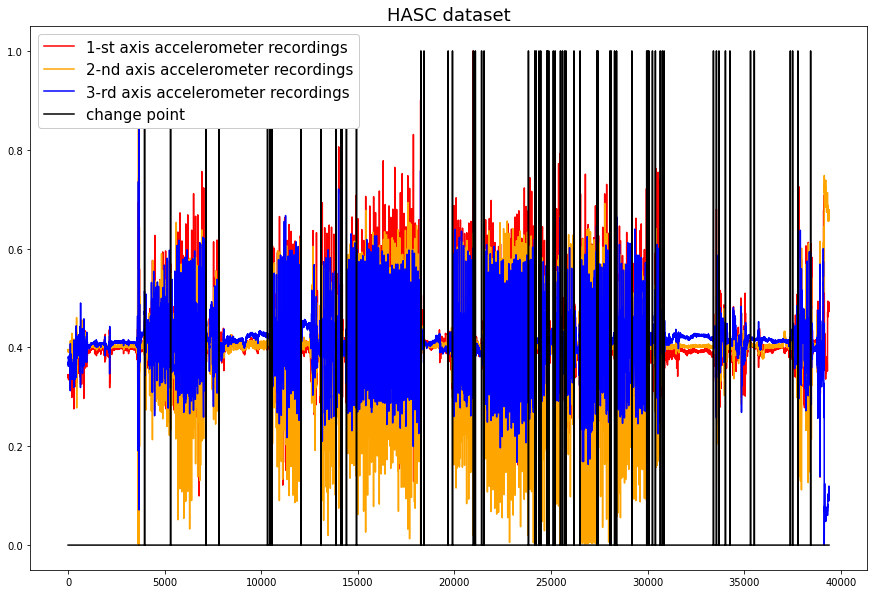

In [5]:
plt.figure(figsize = (15, 10))
plt.title("HASC dataset", fontsize = 18)
plt.plot(dataset["Y"][:,0], color = "red", label = "1-st axis accelerometer recordings");
plt.plot(dataset["Y"][:,1], color = "orange", label = "2-nd axis accelerometer recordings");
plt.plot(dataset["Y"][:,2], color = "blue", label = "3-rd axis accelerometer recordings");
plt.plot(dataset["L"], color = "black", label = "change point");
plt.legend(framealpha=1, fontsize = 15);




# HASC preprocess

In [6]:
def extract_windows(path, window_size, step):

    dataset = sio.loadmat(path+"hasc.mat")
    windows = []
    lbl = []
    first = True
    num_cp = 0
    x = np.array(dataset['Y'])
    cp = np.array(dataset['L'])

    ts = np.sqrt(np.power(x[:, 0], 2) + np.power(x[:, 1], 2) + np.power(x[:, 2], 2))
    #print("ts", ts[:20] ,"\n")
    
    #print("ts.shape[0] - window_size", ts.shape[0] - window_size, "\n")
    
    for i in range(0, ts.shape[0] - window_size, step):
        windows.append(np.array(ts[i:i + window_size]))
        #print("TS",ts[i:i+window_size])
        is_cp = np.where(cp[i:i + window_size] == 1)[0]
        if is_cp.size == 0:
            is_cp = [0]
        else:
            #print(i)
            #print("is_cp", is_cp)
            num_cp += 1
        lbl.append(is_cp[0])

             # print(is_cp)

    print("number of samples : {} /  number of samples with change point : {}".format(len(windows), num_cp))
    windows = np.array(windows)

    return windows, np.array(lbl)

def load_hasc_ds(path, window, train_share = 0.8, step = 5, mode='train'):

    X, lbl = extract_windows(path, window, step)

    if mode == "all":
        return X, lbl

    train_size = floor(train_share * X.shape[0])
    print(train_size)
    if mode == "train":
        trainx = X[0:train_size]
        trainlbl =lbl[0:train_size]
        idx = np.arange(trainx.shape[0])
        np.random.shuffle(idx)
        trainx = trainx[idx,]
        trainlbl = trainlbl[idx]
        print('train samples : ', train_size)
        return trainx, trainlbl

    else:
        testx = X[train_size:]
        testlbl = lbl[train_size:]
        print('test shape {} and number of change points {} '.format(testx.shape, len(np.where(testlbl>0)[0])))

        return testx, testlbl
    
class Prepare_dataset(torch.utils.data.Dataset):    
    
    def __init__(self, path, labels):
        
        self.path = path
        self.labels = labels
    
    def __len__(self):
        
        return len(self.path)
    
    def __getitem__(self, index):
        series = self.path[index]
        tensor_of_image = torch.tensor(series)
        label = self.labels[index]
        
        return tensor_of_image, label 
        #return np.concatenate((label, tensor_of_image), 1)

def load_dataset(path, ds_name, win, bs, mode="train"):
    if ds_name == 'HASC':
        data, label = load_hasc_ds(path, window = 2 * win, mode=mode)
    elif ds_name == "USC":
        data, label = load_usc_ds(path, window = 2 * win, mode=mode)
    else:
        raise ValueError("Undefined Dataset.")

    label = label.reshape((label.shape[0], 1))
    print(data.shape, label.shape)
    
    #dataset = np.concatenate((trainlbl, trainx), 1)

    #print("dataset shape : ", dataset.shape)
    if mode == "train":
        data_train = Prepare_dataset(data, label)
        dataloader_train = torch.utils.data.DataLoader(data_train,
                                                       batch_size=bs,
                                                       shuffle=True)
        return dataloader_train
        
    
    
    if mode == "test":
        data_test = Prepare_dataset(data, label)
        dataloader_test = torch.utils.data.DataLoader(data_test,
                                                      batch_size=bs,
                                                      shuffle=False)

        return dataloader_test

### Parameters window = 60, code_size = 10

In [11]:
window = 60
code_size = 10
seq_len = window
# as in the article
bs = 64

In [12]:
path= "data/"
dataset = sio.loadmat(path+"hasc.mat")
windows, labels = extract_windows(path = path, window_size=window, step = window)

number of samples : 656 /  number of samples with change point : 63


In [13]:
trainx, trainlbl = load_hasc_ds(path = "data/", window = window*2, train_share = 0.8, step = window, mode='train')
testx, testlbl = load_hasc_ds(path = "data/", window = window*2, train_share = 0.8, step = window, mode='test')

number of samples : 655 /  number of samples with change point : 116
524
train samples :  524
number of samples : 655 /  number of samples with change point : 116
524
test shape (131, 120) and number of change points 22 


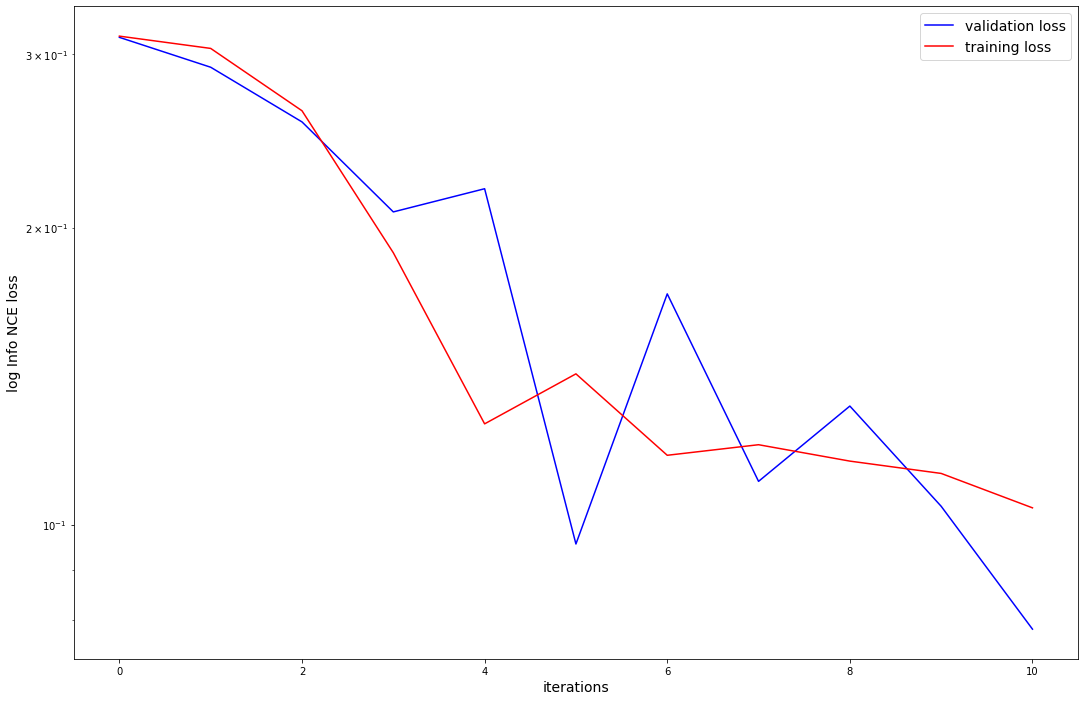

batch tensor([[0.7145, 0.7123, 0.7120,  ..., 0.7081, 0.7028, 0.6990],
        [0.6333, 0.6336, 0.6346,  ..., 0.6858, 0.6837, 0.6759],
        [0.8182, 0.7858, 0.7496,  ..., 0.6102, 0.5870, 0.6104],
        ...,
        [0.5299, 0.5281, 0.5286,  ..., 0.7750, 0.7406, 0.7064],
        [0.6672, 0.6485, 0.6375,  ..., 0.5774, 0.5614, 0.5599],
        [0.6445, 0.6243, 0.5966,  ..., 0.7550, 0.7661, 0.7643]],
       dtype=torch.float64)
batch.shape torch.Size([64, 120])
batch[:,:self.window] tensor([[0.7145, 0.7123, 0.7120,  ..., 0.7180, 0.7161, 0.7174],
        [0.6333, 0.6336, 0.6346,  ..., 0.6763, 0.6785, 0.6690],
        [0.8182, 0.7858, 0.7496,  ..., 0.6953, 0.6681, 0.6358],
        ...,
        [0.5299, 0.5281, 0.5286,  ..., 0.6958, 0.7494, 0.7828],
        [0.6672, 0.6485, 0.6375,  ..., 0.7141, 0.7026, 0.6956],
        [0.6445, 0.6243, 0.5966,  ..., 0.5847, 0.5953, 0.6626]],
       dtype=torch.float64)
batch[:,:self.window].shape torch.Size([64, 60])
batch[:,self.window:] tensor([[0.7156

 55%|█████▌    | 11/20 [04:36<03:46, 25.17s/it]


KeyboardInterrupt: 

In [14]:
epochs = 20
# folowing the article dilations:
dilations = [1, 4, 16]
nb_stacks = 2
kernel_size = 4
nb_filters = 64


encoder = Encoder(c_in = 1, nb_filters=nb_filters, kernel_size=kernel_size, dilations = dilations, 
                  nb_stacks=nb_stacks, n_steps=50, code_size=code_size, seq_len=seq_len)

model = TSCP_model(
    model=encoder,
    train_dataset=trainx,
    test_dataset=testx,
    batch_size=bs,
    num_workers=4,
    temperature = 0.1,
    lr= 0.0001,
    decay_steps= 1000,
    window_1 = window,
    window_2= window
)

model = model.to(device)

optimizer = model.configure_optimizers()

train_loader = model.train_dataloader()
val_loader = model.val_dataloader()

train_losses = []
val_losses = []

total_iterations = 0
for epoch in tqdm(range(epochs)):
    
    iteration = 0
    train_losses_4_iters = []
    
    for index, batch in enumerate(train_loader):
        
        bat
        
        if iteration != 5:
            
            loss = model.training_step(batch, index)
            train_losses_4_iters.append(float(loss))
            #print("train_losses_4_iters", train_losses_4_iters)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            iteration += 1
            
            #print("iteration", iteration)
        
        else:
            model.eval()
            val_loss = model.validation_step(batch, index)
            #print("val_loss", val_loss)
            val_losses.append(float(val_loss.detach()))
            #print("val_losses", val_losses)
            train_losses.append(np.mean(train_losses_4_iters))
            #print("train_losses", train_losses)
            
            val_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iteration = 0
            train_losses_4_iters = []
            
            clear_output(wait=True)
            plt.figure(figsize=(18, 12))
            
            plt.plot(val_losses, label = "validation loss", color = "blue")
            plt.plot(train_losses, label = "training loss", color = "red")
            plt.yscale("log")
            plt.ylabel("log Info NCE loss", fontsize = 14)
            plt.xlabel("iterations", fontsize = 14)
            plt.legend(fontsize = 14)
            plt.show();
            model.train()
            

In [ ]:
 def validation_step(self, batch, batch_idx):

    history, future = batch, batch

    history_emb = self.forward(history.float())
    future_emb = self.forward(future.float()) 

    history_emb = nn.functional.normalize(history_emb, p=2, dim=1)
    future_emb = nn.functional.normalize(future_emb, p=2, dim=1)


    val_loss, pos_sim, neg_sim = nce_loss_fn(history_emb, future_emb, similarity=_cosine_simililarity_dim2, 
                                             temperature=self.temperature)

    self.log("val_loss", val_loss, prog_bar=False)     
    self.log("val_pos_sim", pos_sim, prog_bar=False)        
    self.log("val_neg_sim", neg_sim, prog_bar=False)        

    return val_loss

# Check embeddings

In [152]:
from tscp_new import _cosine_simililarity_dim1

In [153]:
cosines = []
for index, data in enumerate(tqdm(val_loader)):
    #print(data.double().shape)
    
    res = model(torch.tensor(data, dtype = torch.float32))
    #print(res.shape)
    for i in range(30):
        #print(f"{i} original pair of series")
        init_series_1 = data[i,:60]
        init_series_2 = data[i,60:]
        #plt.plot(init_series_1)
        #plt.plot(init_series_2)
        #plt.show()

        #print(f"{i} embedded pair of series")
        embed_1 = res.detach()[i,:5]
        embed_2 = res.detach()[i,5:]
        
        #plt.plot(embed_1)
        #plt.plot(embed_2)
        #plt.show()
        
        cos = _cosine_simililarity_dim1(embed_1.reshape(1,-1), embed_2.reshape(1,-1))
        #print("cosine =", cos)
        cosines.append(cos)
        
        #print("#"*100)
    
    


100%|██████████| 25/25 [00:13<00:00,  1.89it/s]


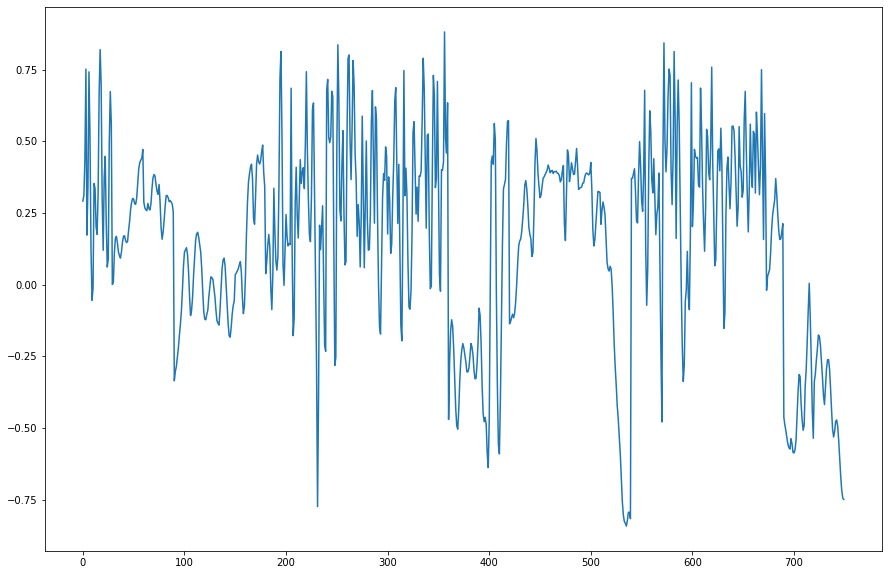

In [155]:
plt.figure(figsize = (15,10))
plt.plot(cosines);
# 20 epochs

# Check F1

In [157]:
len(labels)

656

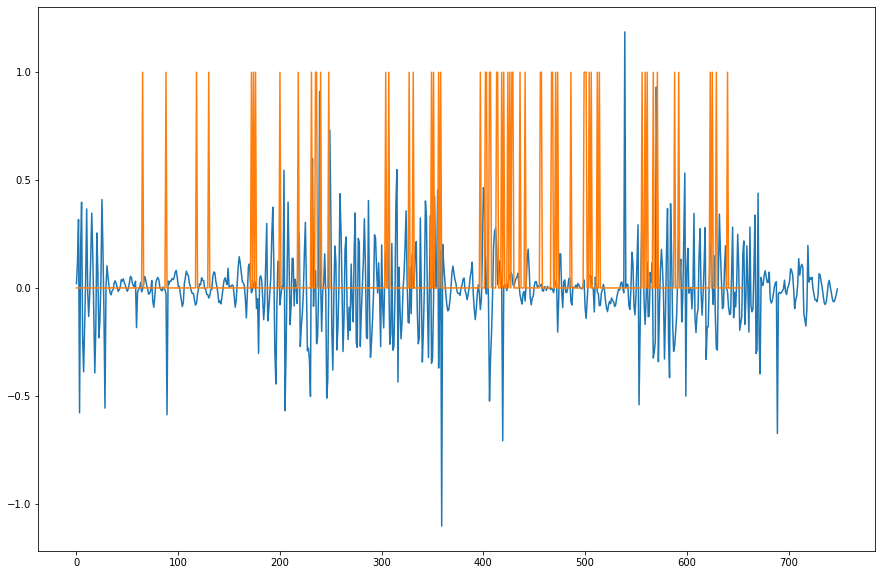

In [178]:
plt.figure(figsize = (15,10))
plt.plot(torch.tensor(cosines).diff());
plt.plot(labels>0);

# USC part

## Illustration USC dataset

In [34]:
path= "data/"
dataset = sio.loadmat(path+"usc.mat")

In [35]:
dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Oct 19 14:01:57 2020',
 '__version__': '1.0',
 '__globals__': [],
 'L': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'Y': array([[0.179207  ],
        [0.16998498],
        [0.16555306],
        ...,
        [0.33397986],
        [0.33366157],
        [0.3323591 ]])}

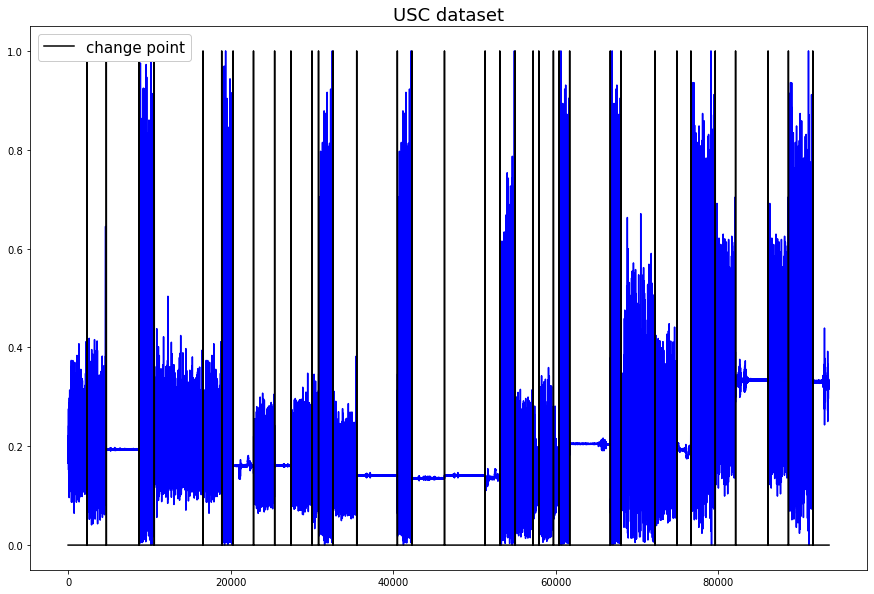

In [36]:
plt.figure(figsize = (15, 10))
plt.title("USC dataset", fontsize = 18)
plt.plot(dataset["Y"], color = "blue");
plt.plot(dataset["L"], color = "black", label = "change point");
plt.legend(framealpha=1, fontsize = 15);


